In [1]:
!pip install Pillow

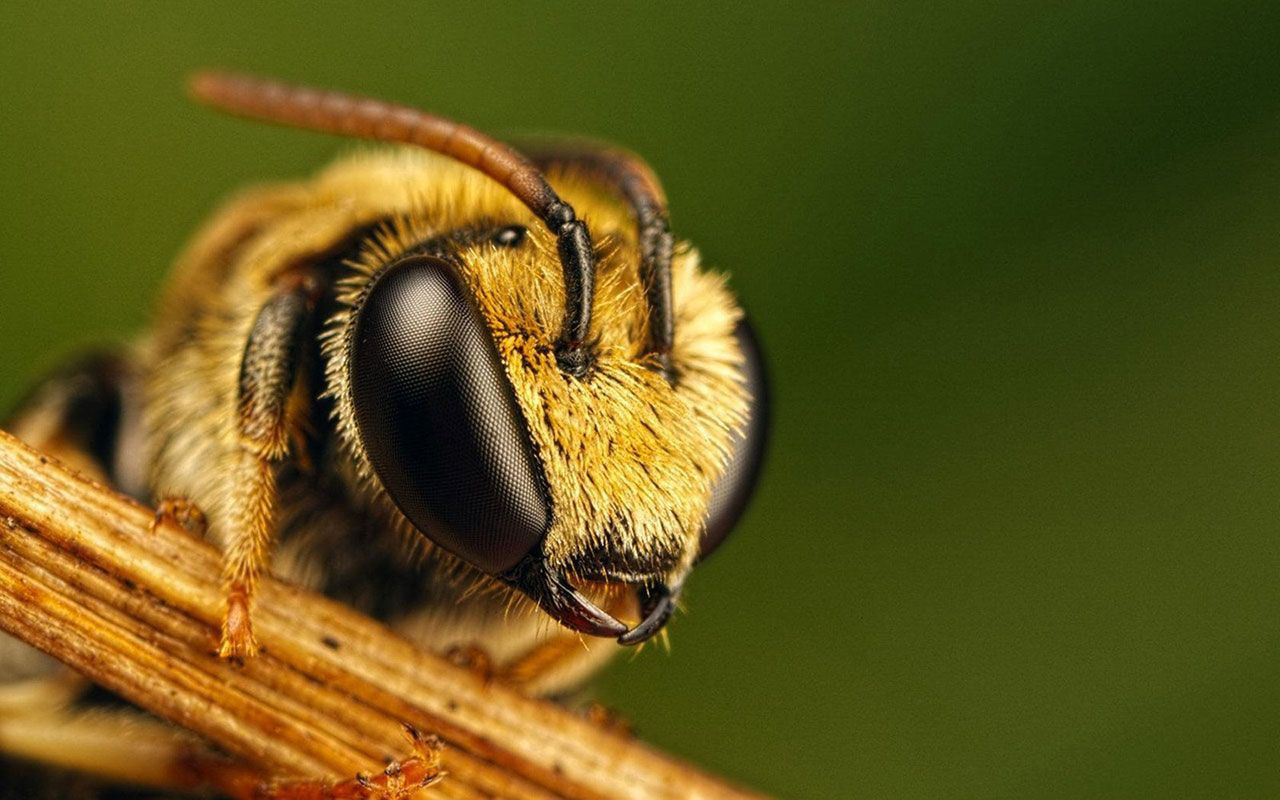

In [2]:
from PIL import Image
img = Image.open('./assets/bee.jpeg')
CHUNK_LENGTH = 16
BITS_PER_BYTE = 2

In [3]:
def to_bin(num):
    return str(bin(int(num)))[2:]

In [4]:
def to_int(num):
    return int(num, 2)

In [5]:
def serialize(text):
    return ''.join(to_bin(ord(char)).rjust(CHUNK_LENGTH, '0') for char in text)

In [6]:
def chunk_string(string, length=1):
    return (string[i:length+i] for i in range(0, len(string), length))

In [7]:
def calc_img_encode_size(img):
    # BITS_PER_BYTE bits per color channel per pixel
    return BITS_PER_BYTE * 3 * img.width * img.height

In [8]:
def encode_in_pixel(pixel_val, data):
    if pixel_val > 255:
        raise ValueError('Pixel value cannot be greater than 255')

    pixel_val_in_bin = to_bin(pixel_val)[:-2]
    return to_int(pixel_val_in_bin + data)

In [9]:
def encrypt_into_image(img, text: str):
    img = img.copy()
    pixels = img.load()
    available_space = calc_img_encode_size(img)
    data_to_hide = serialize(text)

    if available_space < len(data_to_hide):
        raise ValueError('Too much data to encode in this image')

    # pad the end of data with zeroes
    data_to_hide = data_to_hide + '0' * (available_space - len(data_to_hide))


    chunks = list(chunk_string(data_to_hide, 2))
    index = 0
    for x in range(img.width):
        for y in range(img.height):
            r, g, b = pixels[x, y]
            r = encode_in_pixel(r, chunks[index+0])
            g = encode_in_pixel(g, chunks[index+1])
            b = encode_in_pixel(b, chunks[index+2])
            index+=3
            pixels[x, y] = (r, g, b)
    return img

In [10]:
def compare_images(img1, img2):
    if img1.width != img2.width or img1.height != img2.height:
        return False
    
    comparision_img = Image.new("RGB", (img1.width, img1.height))
    
    pixels1 = img1.load()
    pixels2 = img2.load()
    comparision_pixels = comparision_img.load()
    for x in range(img1.width):
        for y in range(img1.height):
            comparision_pixels[x, y] = tuple(abs(a-b)*10 for a, b in zip(pixels1[x, y], pixels2[x, y]))
    return comparision_img

In [11]:
def decode(img):
    img = img.copy()
    pixels = img.load()

    # first step is to get the binary representation of the string from the image
    extracted_chunks_list = []
    for x in range(img.width):
        for y in range(img.height):
            extracted_chunks_list.append(''.join(to_bin(pixel_val)[-2:] for pixel_val in pixels[x, y]))
    binary_string = ''.join(extracted_chunks_list)

    letters_in_binary = map(lambda x: x.lstrip('0'), chunk_string(binary_string, CHUNK_LENGTH))
    return ''.join(chr(to_int(char)) for char in letters_in_binary if char)

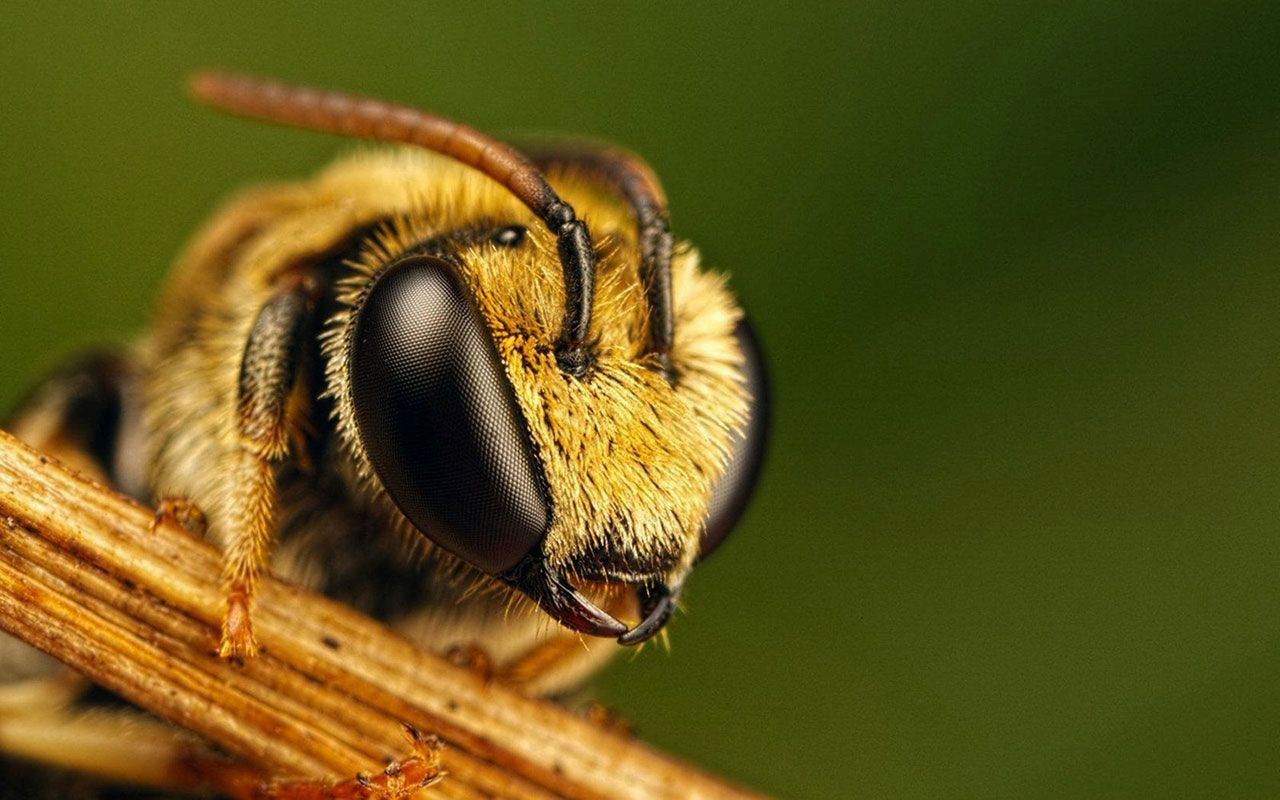

In [12]:
new_img = encrypt_into_image(img, 'hello world')
new_img

In [13]:
decode(new_img)

'hello world'